In [ ]:
import pandas as pd
import gc
import numpy as np
import datetime
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from sklearn.preprocessing import LabelEncoder

import platform
# 차트에서 한글 출력을 위한 설정
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()

    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

device = torch.device('cuda')


gc.collect()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


0

In [ ]:
df_tr = pd.read_csv('train.csv', encoding = "utf-8")
test = pd.read_csv('test.csv', encoding = "utf-8")
test = test.loc[test['PM2.5'].isna() == False].reset_index().iloc[:,1:]

sub = pd.read_csv('answer_sample.csv')

In [ ]:
df_tr.shape, test.shape

((596088, 9), (52224, 9))

## Feature Extraction

In [ ]:
df_tr.head()

,연도,일시,측정소,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),PM2.5
0,0,01-01 00:00,공주,0.173776,0.201944,0.023018,0.0,0.828,0.056
1,0,01-01 01:00,공주,0.176935,0.168611,0.030691,0.0,0.831,0.060
2,0,01-01 02:00,공주,0.180095,0.087222,0.033248,0.0,0.784,0.068
3,0,01-01 03:00,공주,0.178515,0.087222,0.025575,0.0,0.745,0.060
4,0,01-01 04:00,공주,0.164297,0.113889,0.020460,0.0,0.750,0.068


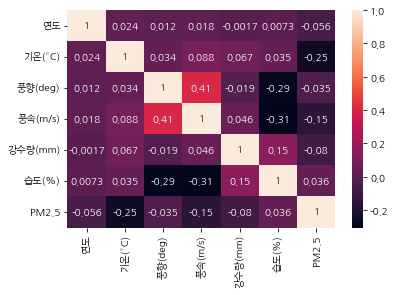

In [ ]:
sns.heatmap(df_tr.corr(), annot = True)
plt.show()

In [ ]:
# 측정소 encoding
enc = LabelEncoder()

df_tr['측정소'] = enc.fit_transform(df_tr['측정소'])
test['측정소'] = enc.transform(test['측정소'])

## DataLoader

In [ ]:
df_tr

,연도,일시,측정소,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),PM2.5
0,0,01-01 00:00,0,0.173776,0.201944,0.023018,0.0,0.828,0.056
1,0,01-01 01:00,0,0.176935,0.168611,0.030691,0.0,0.831,0.060
2,0,01-01 02:00,0,0.180095,0.087222,0.033248,0.0,0.784,0.068
3,0,01-01 03:00,0,0.178515,0.087222,0.025575,0.0,0.745,0.060
4,0,01-01 04:00,0,0.164297,0.113889,0.020460,0.0,0.750,0.068
...,...,...,...,...,...,...,...,...,...
596083,3,12-31 19:00,16,0.273302,0.832222,0.086957,0.0,0.671,0.060
596084,3,12-31 20:00,16,0.271722,0.831667,0.043478,0.0,0.692,0.052
596085,3,12-31 21:00,16,0.268562,0.832500,0.066496,0.0,0.706,0.044
596086,3,12-31 22:00,16,0.262243,0.866944,0.043478,0.0,0.725,0.052


In [ ]:
test

,연도,일시,측정소,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),PM2.5
0,4,01-01 00:00,0,0.244866,0.123333,0.038363,0.0,0.647,0.060
1,4,01-01 01:00,0,0.232227,0.167778,0.033248,0.0,0.648,0.064
2,4,01-01 02:00,0,0.206951,0.000000,0.002558,0.0,0.734,0.072
3,4,01-01 03:00,0,0.199052,0.000000,0.002558,0.0,0.753,0.064
4,4,01-01 04:00,0,0.189573,0.000000,0.002558,0.0,0.795,0.056
...,...,...,...,...,...,...,...,...,...
52219,4,11-13 19:00,16,0.477093,0.716944,0.030691,0.0,0.911,0.160
52220,4,11-13 20:00,16,0.494471,0.575833,0.012788,0.0,0.933,0.172
52221,4,11-13 21:00,16,0.458136,0.772222,0.043478,0.0,0.982,0.160
52222,4,11-13 22:00,16,0.483412,0.000000,0.007673,0.0,0.982,0.156


In [ ]:
# 피처 clustering

In [ ]:
df_tr['일시_datetime'] = pd.to_datetime('2020-' + df_tr['일시'], format='%Y-%m-%d %H:%M')

In [ ]:
df_tr['hour'] = df_tr['일시_datetime'].dt.hour
df_tr['day'] = df_tr['일시_datetime'].dt.day
df_tr['month'] = df_tr['일시_datetime'].dt.month
df_tr['week'] = df_tr['일시_datetime'].dt.isocalendar().week

In [ ]:
df_tr = df_tr.drop('일시_datetime', axis=1)

In [ ]:
#######################################
## 측정소, 요일별, 시간별 발전량 평균 넣어주기
#######################################
PM_mean = pd.pivot_table(df_tr, values = 'PM2.5', index = ['측정소', 'hour', 'day'], aggfunc = np.mean).reset_index()
tqdm.pandas()
df_tr['day_hour_mean'] = df_tr.progress_apply(lambda x : PM_mean.loc[(PM_mean.측정소 == x['측정소']) & (PM_mean.hour == x['hour']) & (PM_mean.day == x['day']) ,'PM2.5'].values[0], axis = 1)

100% 596088/596088 [04:48<00:00, 2066.39it/s]


In [ ]:
#######################################
## 측정소 시간별 발전량 평균 넣어주기
#######################################
PM_hour_mean = pd.pivot_table(df_tr, values = 'PM2.5', index = ['측정소', 'hour'], aggfunc = np.mean).reset_index()
tqdm.pandas()
df_tr['hour_mean'] = df_tr.progress_apply(lambda x : PM_hour_mean.loc[(PM_hour_mean.측정소 == x['측정소']) & (PM_hour_mean.hour == x['hour']) ,'PM2.5'].values[0], axis = 1)

100% 596088/596088 [03:13<00:00, 3083.00it/s]


In [ ]:

#######################################
## 측정소 시간별 발전량 표준편차 넣어주기
#######################################
PM_hour_std = pd.pivot_table(df_tr, values = 'PM2.5', index = ['측정소', 'hour'], aggfunc = np.std).reset_index()
tqdm.pandas()
df_tr['hour_std'] = df_tr.progress_apply(lambda x : PM_hour_std.loc[(PM_hour_std.측정소 == x['측정소']) & (PM_hour_std.hour == x['hour']) ,'PM2.5'].values[0], axis = 1)

100% 596088/596088 [03:13<00:00, 3088.40it/s]


In [ ]:
df_tr['sin_time'] = np.sin(2*np.pi*df_tr.hour/24)
df_tr['cos_time'] = np.cos(2*np.pi*df_tr.hour/24)

In [ ]:
df_tr['THI'] = 9/5*df_tr['기온(°C)'] - 0.55*(1-df_tr['습도(%)']/100)*(9/5*df_tr['습도(%)']-26)+32

In [ ]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(0,17,1):
    temp = df_tr[df_tr['측정소'] == num]
    cdh = CDH(temp['기온(°C)'].values)
    cdhs = np.concatenate([cdhs, cdh])
df_tr['CDH'] = cdhs

In [ ]:
#test

In [ ]:
test['일시_datetime'] = pd.to_datetime('2020-' + test['일시'], format='%Y-%m-%d %H:%M')

In [ ]:
test['hour'] = test['일시_datetime'].dt.hour
test['day'] = test['일시_datetime'].dt.day
test['month'] = test['일시_datetime'].dt.month
test['week'] = test['일시_datetime'].dt.isocalendar().week

In [ ]:
test = test.drop('일시_datetime', axis=1)

In [ ]:
#######################################
## 측정소, 요일별, 시간별 발전량 평균 넣어주기
#######################################
PM_mean = pd.pivot_table(test, values = 'PM2.5', index = ['측정소', 'hour', 'day'], aggfunc = np.mean).reset_index()
tqdm.pandas()
test['day_hour_mean'] = test.progress_apply(lambda x : PM_mean.loc[(PM_mean.측정소 == x['측정소']) & (PM_mean.hour == x['hour']) & (PM_mean.day == x['day']) ,'PM2.5'].values[0], axis = 1)

100% 52224/52224 [00:25<00:00, 2067.53it/s]


In [ ]:
#######################################
## 측정소 시간별 발전량 평균 넣어주기
#######################################
PM_hour_mean = pd.pivot_table(test, values = 'PM2.5', index = ['측정소', 'hour'], aggfunc = np.mean).reset_index()
tqdm.pandas()
test['hour_mean'] = test.progress_apply(lambda x : PM_hour_mean.loc[(PM_hour_mean.측정소 == x['측정소']) & (PM_hour_mean.hour == x['hour']) ,'PM2.5'].values[0], axis = 1)

100% 52224/52224 [00:17<00:00, 2991.40it/s]


In [ ]:

#######################################
## 측정소 시간별 발전량 표준편차 넣어주기
#######################################
PM_hour_std = pd.pivot_table(test, values = 'PM2.5', index = ['측정소', 'hour'], aggfunc = np.std).reset_index()
tqdm.pandas()
test['hour_std'] = test.progress_apply(lambda x : PM_hour_std.loc[(PM_hour_std.측정소 == x['측정소']) & (PM_hour_std.hour == x['hour']) ,'PM2.5'].values[0], axis = 1)

100% 52224/52224 [00:17<00:00, 3027.75it/s]


In [ ]:
test['sin_time'] = np.sin(2*np.pi*test.hour/24)
test['cos_time'] = np.cos(2*np.pi*test.hour/24)

In [ ]:
test['THI'] = 9/5*test['기온(°C)'] - 0.55*(1-test['습도(%)']/100)*(9/5*test['습도(%)']-26)+32

In [ ]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(0,17,1):
    temp = test[test['측정소'] == num]
    cdh = CDH(temp['기온(°C)'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

In [ ]:
cols = list(df_tr.columns)
cols.append(cols.pop(cols.index('PM2.5')))
df_tr = df_tr[cols]

In [ ]:
cols = list(test.columns)
cols.append(cols.pop(cols.index('PM2.5')))
test = test[cols]

In [ ]:
df_tr.to_csv('train_02.csv', encoding='utf-8', index=False)

In [ ]:
test.to_csv('test_02.csv', encoding='utf-8', index=False)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 군집화할 데이터
X = df_tr[['기온(°C)']]

# 클러스터 개수 범위 설정
n_clusters = range(5, 15)

# 각 클러스터 개수별로 군집화 모델 생성 및 응집도 계산
inertias = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# 그래프 그리기
plt.plot(n_clusters, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()
